In [ ]:
# Instructions:

# Create a dataloader to use in the training.
# Build VGG16 model without BatchNormalization and train the model. Please add a link to reference used to obtain information about VGG16 in the notebook.
# Add BatchNormalization to the VGG16 and compare the result before and after.
# Add data augmentation and compare the result.

# Summarize and explain the effect of the changes made in each step.
# Make sure you deliver two notebooks and the exported PDFs of these notebooks.

## **Imports**

In [ ]:
import os
import copy
import torch
import kagglehub
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Check if GPU is available
print("CUDA Available:", torch.cuda.is_available())

# Print GPU device name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

CUDA Available: True
GPU Name: Tesla T4


In [ ]:
torch.manual_seed(17)

## **Get the Dataset**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("aielawady/arsl-256")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


## **Dataset Investigation**

In [ ]:
n_images = 0
images, classes = [], []

classes_dist = {}

for dirname, _, filenames in os.walk('/kaggle/input'):

    for filename in filenames:

        # print(os.path.join(dirname, filename))
        n_images += 1
        class_name = filename.split('_')[0]

        images.append(dirname+'/'+filename)
        classes.append(class_name)

        classes_dist[class_name] = classes_dist.get(class_name, 0) + 1


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
n_classes = len(classes_dist)
print('Total Number Of Classes Found:', n_classes)

Total Number Of Classes Found: 30


In [ ]:
print('Total Images Found:', n_images)

Total Images Found: 7855


In [ ]:
print('Classes Distribution:\n', classes_dist)

Classes Distribution:
 {'Zain': 201, 'Zah': 232, 'Meem': 253, 'Seen': 266, 'Teh': 568, 'Lam': 260, 'Dad': 266, 'Reh': 227, 'Sad': 270, 'Dal': 235, 'Sheen': 278, 'Hah': 246, 'Beh': 307, 'Tah': 226, 'Alef': 287, 'Waw': 249, 'Qaf': 219, 'Al': 276, 'Ghain': 230, 'Heh': 253, 'Ain': 244, 'Kaf': 264, 'thal': 202, 'Feh': 255, 'Khah': 250, 'Yeh': 271, 'Jeem': 210, 'Theh': 305, 'Noon': 237, 'Laa': 268}


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


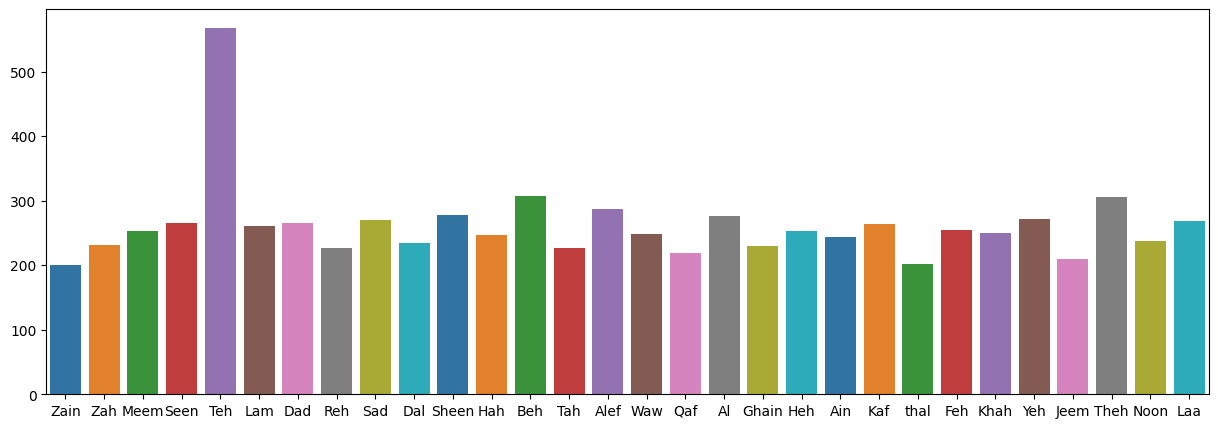

In [ ]:
plt.figure(figsize=(15, 5))
sns.barplot(x=list(classes_dist.keys()), y=list(classes_dist.values()), palette='tab10')
plt.show()

In [ ]:
# print('Images Found:\n', images)

In [ ]:
# print('Labels Found:\n', classes)

## **Encode Labels**

In [ ]:
original_labels = np.array(list(classes_dist.keys()))
label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(classes)

In [ ]:
# for original, mapped in zip(classes, encoded_labels):
#     print(f'{original} -> {mapped}')

# Teh -> 23

## **Dataset Preparation**

In [ ]:
class CustomDataset(Dataset):
    """Arabic Sign Language Dataset."""

    def __init__(self, images, labels, scaler=None, transform=None, aug=False) -> None:
        '''
        Args:
            images (list):
            labels (list):
            transform (callable, optional): Optional transform to be applied on a sample.

        Returns:
          None
        '''

        # Define the images
        self.images = images

        # Define the labels
        self.labels = labels


        # Define the transformations if any were given
        self.transform = transform

        # A flag to see if this dataset is for augmentation purpose or not
        self.aug = aug




    def __len__(self) -> int:

        '''
        Args:
            None

        Returns:
          None
        '''
        return len(self.images)




    def __getitem__(self, idx) -> tuple:

        '''
        Args:
            idx(tensor):

        Returns:

        '''

        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.transform:
            image = Image.open(self.images[idx])
            image = self.transform(image)

        # Convert to tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        # # Avoid augmenting the Teh class (to create some class balance), if we are in augmentation mode
        # if self.aug and label.item() == 23:
        #     return self.__getitem__((idx + 1) % len(self.images))  # get a different sample

        return image, label

In [ ]:
transform =   transforms.Compose([
                                  transforms.Resize((224, 224)),
                                  #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
                                  transforms.PILToTensor(),
                                  transforms.ConvertImageDtype(torch.float),
                                  transforms.Normalize((0.5,), (0.5,))
                                  #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, train_size=0.8, random_state=42, shuffle=True)

In [ ]:
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

In [ ]:
print('Length of the Training Dataset:',len(train_dataset))
print('Length of the Test Dataset:',len(test_dataset))

train_sample = next(iter(train_dataset))
print('Image Shape:', train_sample[0].shape)
print('Label Shape:', train_sample[1].shape)

Length of the Training Dataset: 6284
Length of the Test Dataset: 1571
Image Shape: torch.Size([3, 224, 224])
Label Shape: torch.Size([])


In [ ]:
# Wrap in DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Verify the training dataloader formed
print('Type of Training Dataloader:', type(train_loader))
print('Length of Training Dataloader (number of training batches formd):', len(train_loader))
print('\nObserve the first batch of training data:')
print('\tShape of features:', next(iter(train_loader))[0].shape)
print('\tShape of labels:', next(iter(train_loader))[1].shape)

Type of Training Dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
Length of Training Dataloader (number of training batches formd): 197

Observe the first batch of training data:
	Shape of features: torch.Size([32, 3, 224, 224])
	Shape of labels: torch.Size([32])


In [ ]:
# Verify the test dataloader formed
print('Type of Test Dataloader:', type(test_loader))
print('Length of Test Dataloader (number of test batches formd):', len(test_loader))
print('\nObserve the first batch of test data:')
print('\tShape of features:', next(iter(test_loader))[0].shape)
print('\tShape of labels:', next(iter(test_loader))[1].shape)

Type of Test Dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
Length of Test Dataloader (number of test batches formd): 50

Observe the first batch of test data:
	Shape of features: torch.Size([32, 3, 224, 224])
	Shape of labels: torch.Size([32])


## **Device Definition**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Model Calling**

In [ ]:
class VGG16NonBatchNormalized(nn.Module):


    def __init__(self, n_classes=1000):

        super().__init__()

        self.features = nn.Sequential(
                                        # Block 1
                                        nn.Conv2d(3, 64, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=2, stride=2),


                                        # Block 2
                                        nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=2, stride=2),


                                        # Block 3
                                        nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=2, stride=2),


                                        # Block 4
                                        nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=2, stride=2),


                                        # Block 5
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=2, stride=2)
                                    )


        self.classifier = nn.Sequential(
                                        nn.Linear(512 * 7 * 7, 4096),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(),

                                        nn.Linear(4096, 4096),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(),

                                        nn.Linear(4096, n_classes)
                                    )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten all except batch
        x = self.classifier(x)
        return x

In [ ]:
class VGG16BatchNormalized(nn.Module):


    def __init__(self, n_classes=1000):

        super().__init__()

        self.features = nn.Sequential(
                                        # Block 1
                                        nn.Conv2d(3, 64, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=2, stride=2),


                                        # Block 2
                                        nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=2, stride=2),


                                        # Block 3
                                        nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=2, stride=2),

                                        # Block 4
                                        nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=2, stride=2),

                                        # Block 5
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=2, stride=2)
                                    )


        self.classifier = nn.Sequential(
                                        nn.Linear(512 * 7 * 7, 4096),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(),

                                        nn.Linear(4096, 4096),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(),

                                        nn.Linear(4096, n_classes)
                                    )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten all except batch
        x = self.classifier(x)
        return x

In [ ]:
#models.vgg16_bn(pretrained = True)

In [ ]:
class TransferLearningModel(nn.Module):

    def __init__(self, n_classes, batch_n=False):

        super().__init__()

        if batch_n:
            self.model = VGG16BatchNormalized(n_classes)

        else:
            self.model = VGG16NonBatchNormalized(n_classes)


    def forward(self, x):
        return self.model(x)

## **Define Objective Function**

In [ ]:
criterion = nn.CrossEntropyLoss()

## **Training & Evaluation Functions**

In [ ]:
def train_model(model, train_loader, n_epochs=20, lr=0.001):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    training_losses = []
    corrects, total = 0, 0


    for epoch in range(n_epochs):

        epoch_loss = 0.0
        corrects, total = 0, 0

        print(f'Epoch {epoch} Started')

        for images, labels in train_loader:

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            y_pred = model(images)
            # print('Y Pred:', y_pred)
            # print('Y Pred Shape:', y_pred.shape)
            # print('Labels:', labels.shape)

            loss = criterion(y_pred, labels)
            epoch_loss += loss.item() * labels.size(0)

            preds = torch.argmax(y_pred, dim=1)
            # print('predsss:', preds)
            # print('predsss Shape:', preds.shape)
            corrects += (labels == preds).sum().item()
            total += labels.size(0)


            loss.backward()
            optimizer.step()


        training_losses.append(epoch_loss / total)
        epoch_training_acc = (corrects / total) * 100
        print(f'Epoch {epoch} Finished with a training accuracy of: {epoch_training_acc} % and a training loss of: {epoch_loss}/n')


    return training_losses

In [ ]:
def evaluate_model(model, test_loader, class_names):

    model.eval()
    test_loss, corrects, total = 0.0, 0, 0

    all_labels, all_preds = [], []

    with torch.no_grad():

        for images, labels in test_loader:

            images, labels = images.to(device), labels.to(device)
            output = model(images)

            preds = torch.argmax(output, dim=1)
            loss = criterion(output, labels)
            test_loss += loss.item() * labels.size(0)

            corrects += (labels == preds).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())    # Store true labels
            all_preds.extend(preds.cpu().numpy())     # Store predicted labels


    print(f'Test Accuracy: {(corrects/total)*100}%, Test Loss: {test_loss/total}')

    # Get Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

## **Testing Phase**

# RGB Channels

### **1- No Batch Normalization**

In [ ]:
vgg16_model_no_batch = TransferLearningModel(n_classes=n_classes).to(device)
training_loss = train_model(vgg16_model_no_batch, train_loader,  n_epochs=50, lr=10e-2)

Epoch 0 Started
Epoch 0 Finished with a training accuracy of: 3.835136855506047 % and a training loss of: 2.753269219471704e+26/n
Epoch 1 Started
Epoch 1 Finished with a training accuracy of: 6.73138128580522 % and a training loss of: 21344.896246910095/n
Epoch 2 Started
Epoch 2 Finished with a training accuracy of: 6.906429026098026 % and a training loss of: 21340.415665626526/n
Epoch 3 Started
Epoch 3 Finished with a training accuracy of: 7.081476766390833 % and a training loss of: 21364.513011932373/n
Epoch 4 Started
Epoch 4 Finished with a training accuracy of: 6.795035009548059 % and a training loss of: 21358.895869255066/n
Epoch 5 Started
Epoch 5 Finished with a training accuracy of: 7.081476766390833 % and a training loss of: 21385.252281188965/n
Epoch 6 Started
Epoch 6 Finished with a training accuracy of: 7.113303628262253 % and a training loss of: 21366.43803882599/n
Epoch 7 Started
Epoch 7 Finished with a training accuracy of: 6.333545512412477 % and a training loss of: 2139

Test Accuracy: 7.829408020369192%, Test Loss: 3.393144932770562


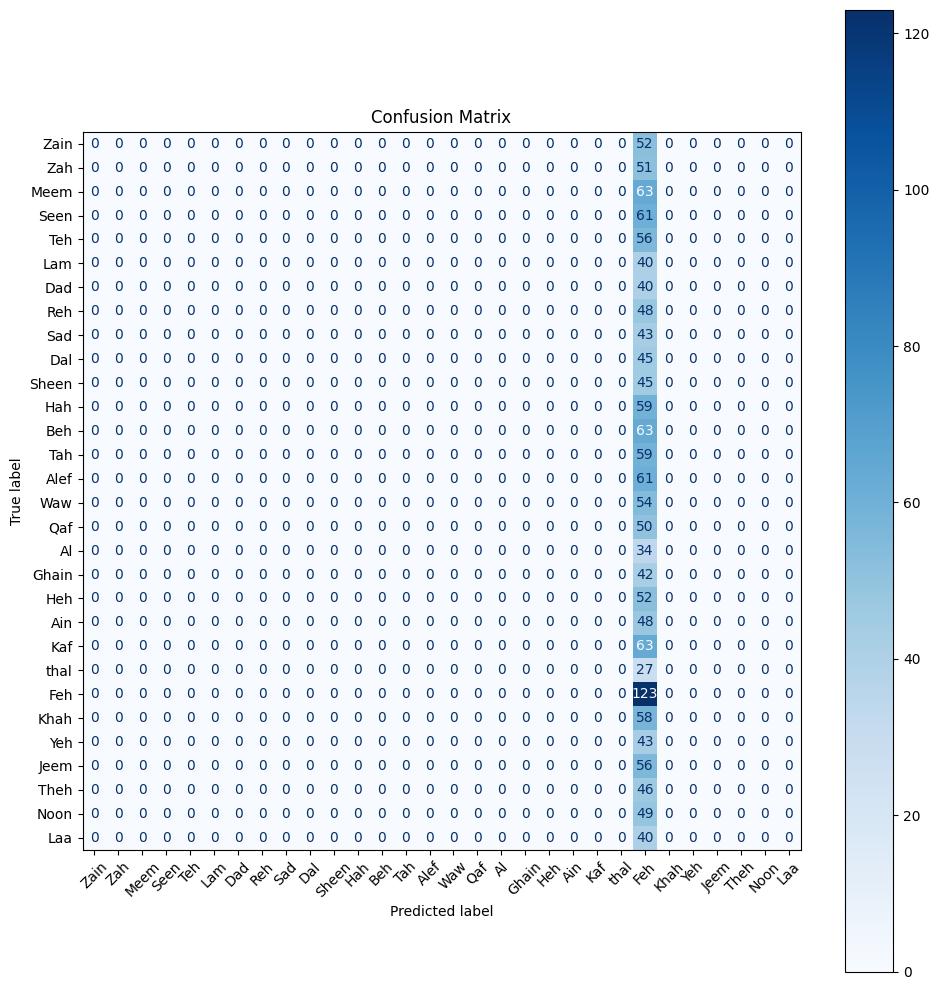

In [ ]:
evaluate_model(vgg16_model_no_batch, test_loader, list(classes_dist.keys()))

### **2- Batch Normalized Approach**

In [ ]:
vgg16_model_batch_norm = TransferLearningModel(n_classes=n_classes, batch_n=True).to(device)
training_loss = train_model(vgg16_model_batch_norm, train_loader, n_epochs=50, lr=10e-2)

Epoch 0 Started
Epoch 0 Finished with a training accuracy of: 5.617441120305537 % and a training loss of: 129431294.41115189/n
Epoch 1 Started
Epoch 1 Finished with a training accuracy of: 7.017823042647994 % and a training loss of: 21381.551845550537/n
Epoch 2 Started
Epoch 2 Finished with a training accuracy of: 6.842775302355188 % and a training loss of: 21397.34226989746/n
Epoch 3 Started
Epoch 3 Finished with a training accuracy of: 6.985996180776575 % and a training loss of: 21397.013175964355/n
Epoch 4 Started
Epoch 4 Finished with a training accuracy of: 6.906429026098026 % and a training loss of: 21392.211376190186/n
Epoch 5 Started
Epoch 5 Finished with a training accuracy of: 7.081476766390833 % and a training loss of: 21395.620858192444/n
Epoch 6 Started
Epoch 6 Finished with a training accuracy of: 7.0496499045194145 % and a training loss of: 21400.78763103485/n
Epoch 7 Started
Epoch 7 Finished with a training accuracy of: 6.938255887969447 % and a training loss of: 21382.

Test Accuracy: 7.829408020369192%, Test Loss: 3.382884086733939


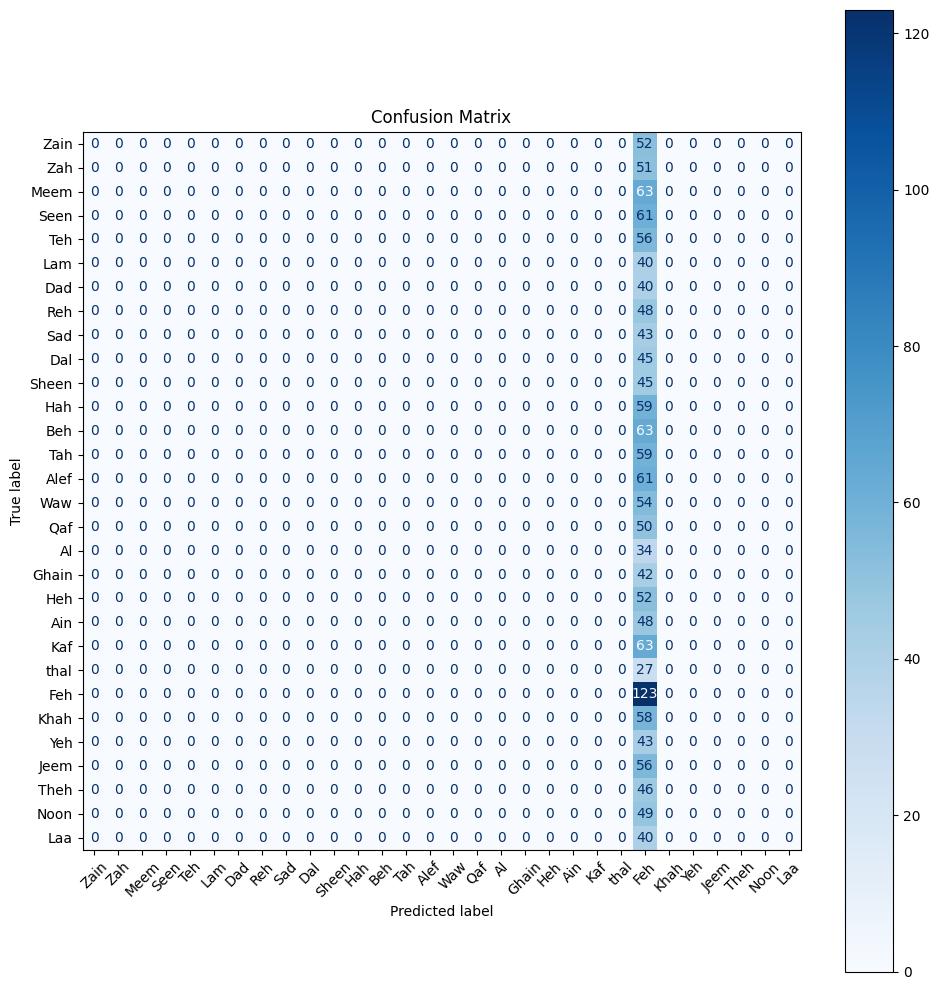

In [ ]:
evaluate_model(vgg16_model_batch_norm, test_loader, list(classes_dist.keys()))

### **3- Augmentation**

In [ ]:
# Define individual augmentations
aug_list = [
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
                transforms.RandomRotation(degrees=30),
                transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
            ]

In [ ]:
# Compose augmentation transform
augmentation_transform = transforms.Compose([
                                             transforms.Resize((224, 224)),
                                             transforms.RandomChoice(aug_list),  # randomly select one augmentation
                                             transforms.PILToTensor(),
                                             transforms.ConvertImageDtype(torch.float),
                                             transforms.Normalize((0.5,), (0.5,))
                                            ])

In [ ]:
aug_dataset = CustomDataset(X_train, y_train, transform=transform, aug=True)# Augment the under-represented classes in the training data
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

# Create the combined training dataset
final_train_dataset = aug_dataset + train_dataset

In [ ]:
# Wrap in DataLoader
final_train_loader = DataLoader(final_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
print('Length of the Final Training Dataset:',len(final_train_dataset))
print('Length of the Test Dataset:',len(test_dataset))

train_sample = next(iter(final_train_dataset))
print('Image Shape:', train_sample[0].shape)
print('Label Shape:', train_sample[1].shape)

Length of the Final Training Dataset: 12568
Length of the Test Dataset: 1571
Image Shape: torch.Size([3, 224, 224])
Label Shape: torch.Size([])


In [ ]:
# Verify the training dataloader formed
print('Type of Training Dataloader:', type(final_train_loader))
print('Length of Training Dataloader (number of training batches formd):', len(final_train_loader))
print('\nObserve the first batch of training data:')
print('\tShape of features:', next(iter(final_train_loader))[0].shape)
print('\tShape of labels:', next(iter(final_train_loader))[1].shape)

Type of Training Dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
Length of Training Dataloader (number of training batches formd): 393

Observe the first batch of training data:
	Shape of features: torch.Size([32, 3, 224, 224])
	Shape of labels: torch.Size([32])


In [ ]:
# Verify the test dataloader formed
print('Type of Test Dataloader:', type(test_loader))
print('Length of Test Dataloader (number of test batches formd):', len(test_loader))
print('\nObserve the first batch of test data:')
print('\tShape of features:', next(iter(test_loader))[0].shape)
print('\tShape of labels:', next(iter(test_loader))[1].shape)

Type of Test Dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
Length of Test Dataloader (number of test batches formd): 50

Observe the first batch of test data:
	Shape of features: torch.Size([32, 3, 224, 224])
	Shape of labels: torch.Size([32])


In [ ]:
vgg16_model_aug = TransferLearningModel(n_classes=n_classes, batch_n=True).to(device)
training_loss = train_model(vgg16_model_aug, final_train_loader, n_epochs=50, lr=10e-2)

Epoch 0 Started
Epoch 0 Finished with a training accuracy of: 6.070973901973265 % and a training loss of: 158942720.4176464/n
Epoch 1 Started
Epoch 1 Finished with a training accuracy of: 6.850732017823042 % and a training loss of: 43000.994621276855/n
Epoch 2 Started
Epoch 2 Finished with a training accuracy of: 7.017823042647994 % and a training loss of: 42822.2417678833/n
Epoch 3 Started
Epoch 3 Finished with a training accuracy of: 6.9700827498408655 % and a training loss of: 42745.063802719116/n
Epoch 4 Started
Epoch 4 Finished with a training accuracy of: 6.826861871419478 % and a training loss of: 42759.66983795166/n
Epoch 5 Started
Epoch 5 Finished with a training accuracy of: 6.763208147676639 % and a training loss of: 42771.48722267151/n
Epoch 6 Started
Epoch 6 Finished with a training accuracy of: 6.8029917250159135 % and a training loss of: 42801.84085845947/n
Epoch 7 Started
Epoch 7 Finished with a training accuracy of: 7.0496499045194145 % and a training loss of: 42893.87

Test Accuracy: 7.829408020369192%, Test Loss: 4.804818956355697


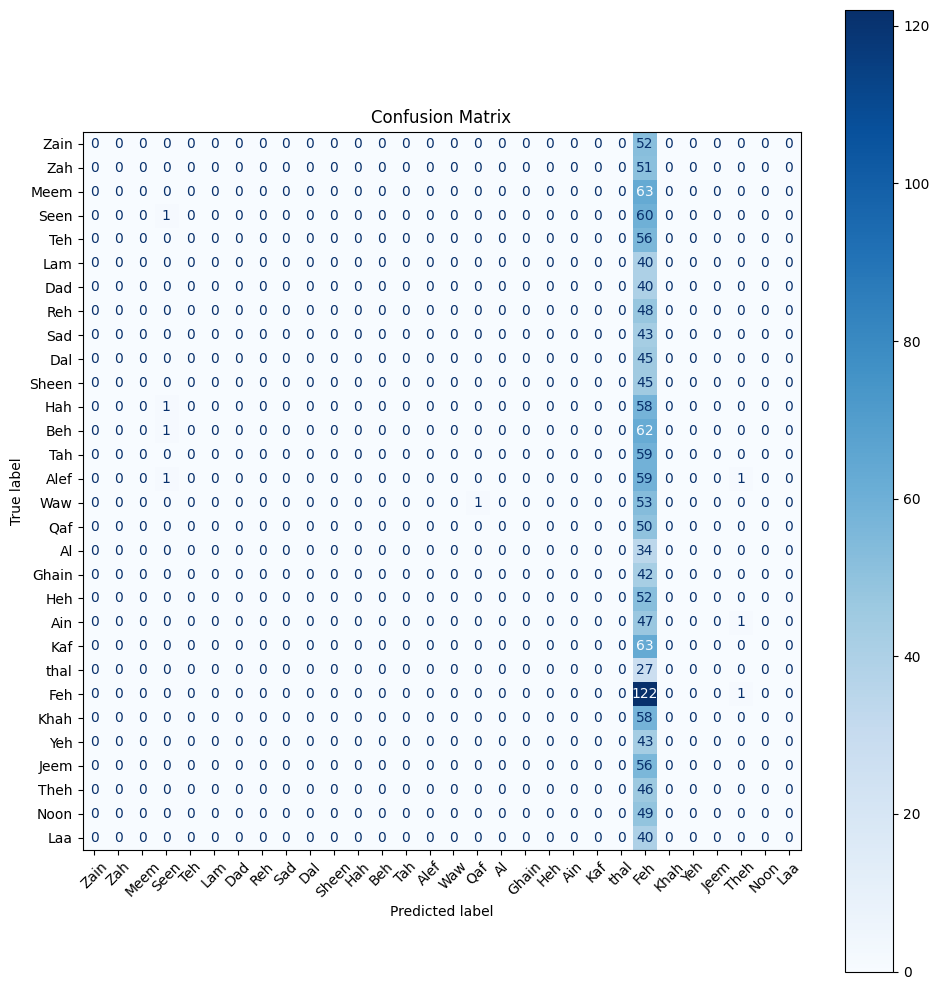

In [ ]:
evaluate_model(vgg16_model_aug, test_loader, list(classes_dist.keys()))

# **Conclusion**

### **1. No Batch Normalization & No Augmentation**

**Training Accuracy:** Fluctuates around ~6.6%–7.08%

**Training Loss:** ~21,380 – 21,404

**Test Accuracy:** 7.83%

**Test Loss:** 3.39


#### **- Findings:**

- The model shows poor generalization and convergence.

- Training accuracy remains low and stagnant.

- Test performance is almost the same as training, indicating underfitting.


### **2. With Batch Normalization Only**

**Training Accuracy:** Remains around ~6.89%–7.08%

**Training Loss:** ~21,390 – 21,394

**Test Accuracy:** 7.83%

**Test Loss:** 3.38


#### **- Findings:**

- Batch normalization stabilizes the training loss slightly.

- Test loss improves slightly compared to the no-BN model.

- However, accuracy gains are negligible — still underfitting and no real learning progress.


### **3. With Batch Normalization + Data Augmentation**

**Training Accuracy:** ~6.96%–7.08%

**Training Loss:** Much higher: ~42,749 – 42,798

**Test Accuracy:** 7.83%

**Test Loss:** 4.80 (significantly worse than others)


### **Key Findings:**

- Augmentation increases training loss as expected (due to more diverse inputs), but no gain in generalization is seen.

- Test loss worsens, and accuracy stagnates at ~7.83%.

- Suggests that model capacity or learning setup (e.g., optimizer, learning rate, data size) may be limiting factors, not augmentation or batch norm.


#### **References**

- **Paper Link:** https://arxiv.org/pdf/1409.1556

- https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918

- https://www.digitalocean.com/community/tutorials/popular-deep-learning-architectures-alexnet-vgg-googlenet